# TITANIC CLASSIFICATION
**Objective:** Make a system which tells whether the person will be save from sinking. What factors were most likely lead to success-socio-economic status, age, gender and more.


# Prerequisites importing

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt

# Import warnings

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Titanic dataset loading

In [ ]:
data = pd.read_csv('/content/titanic.csv')

# Handle missing values

In [ ]:
if 'Age' in data.columns:
    data['Age'].fillna(data['Age'].median(), inplace=True)
if 'Embarked' in data.columns:
    data['Embarked'].fillna(data['Embarked'].mode()[0], inplace=True)
data['Fare'].fillna(data['Fare'].median(), inplace=True)

# Feature engineering

In [ ]:
data['FamilySize'] = data['SibSp'] + data['Parch'] + 1
data['IsAlone'] = (data['FamilySize'] == 1).astype(int)

# Feature selection

In [ ]:
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'FamilySize', 'IsAlone']
target = 'Survived'

# Split the dataset into features (X) and target (y)

In [ ]:
X = data[features]
y = data[target]

# Split into training and test sets

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define preprocessing for numerical and categorical features


In [ ]:
numerical_features = ['Age', 'SibSp', 'Parch', 'Fare', 'FamilySize']
categorical_features = ['Pclass', 'Sex', 'Embarked', 'IsAlone']

numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Handle class imbalance using SMOTE

In [ ]:
smote = SMOTE(random_state=42)
X_train_transformed = preprocessor.fit_transform(X_train)
X_train_smote, y_train_smote = smote.fit_resample(X_train_transformed, y_train)

# Define the model

In [ ]:
model = RandomForestClassifier(random_state=42)

# Hyperparameter tuning

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_smote, y_train_smote)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 20, None],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy')

# Make predictions

In [ ]:
y_pred = grid_search.best_estimator_.predict(preprocessor.transform(X_test))

# Evaluate the model

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.84

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.88      0.86       105
           1       0.82      0.78      0.80        74

    accuracy                           0.84       179
   macro avg       0.83      0.83      0.83       179
weighted avg       0.84      0.84      0.84       179



# Confusion matrix

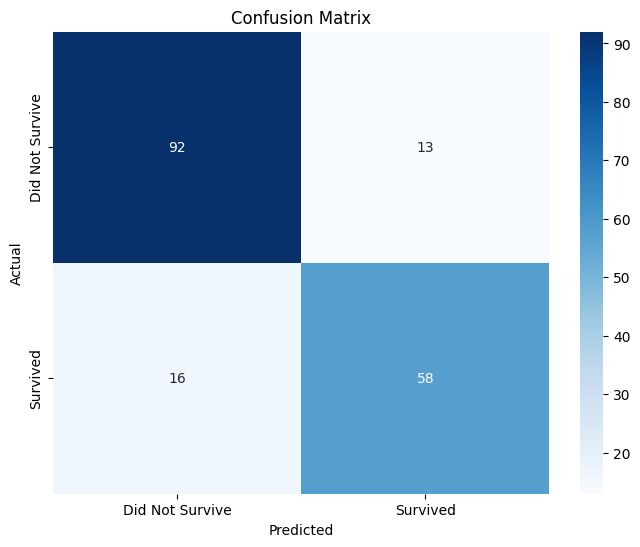

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Did Not Survive', 'Survived'], yticklabels=['Did Not Survive', 'Survived'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Analyze feature importance

In [ ]:
if hasattr(grid_search.best_estimator_, 'feature_importances_'):
    feature_importances = grid_search.best_estimator_.feature_importances_
    feature_names = numerical_features + list(preprocessor.transformers_[1][1].get_feature_names_out())

    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False)

    print("\nFeature Importance:")
    print(feature_importance_df)


Feature Importance:
       Feature  Importance
3         Fare    0.203215
8   Sex_female    0.185252
0          Age    0.177673
9     Sex_male    0.171871
7     Pclass_3    0.053722
4   FamilySize    0.046773
5     Pclass_1    0.030020
1        SibSp    0.028863
2        Parch    0.024697
6     Pclass_2    0.019166
12  Embarked_S    0.017477
10  Embarked_C    0.013623
11  Embarked_Q    0.011243
13   IsAlone_0    0.008268
14   IsAlone_1    0.008138


# Plot feature importance

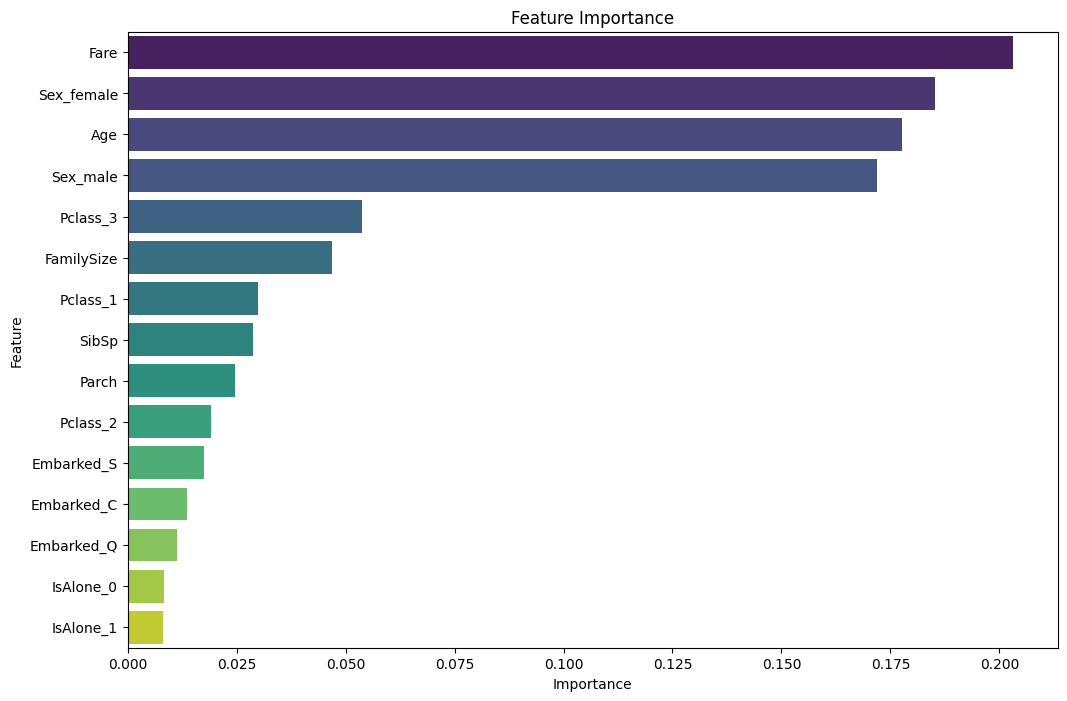

In [ ]:
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Feature Importance')
plt.show()

# Additional visualizations
# Survival distribution

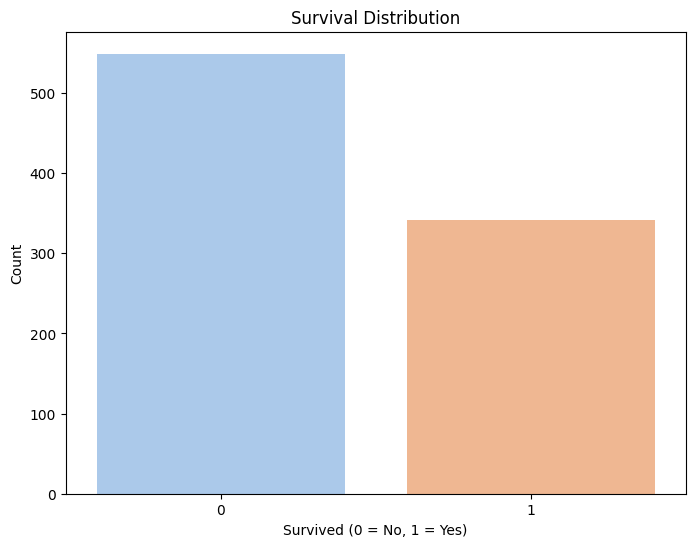

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Survived', data=data, palette='pastel')
plt.title('Survival Distribution')
plt.xlabel('Survived (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.show()

# Age distribution by survival

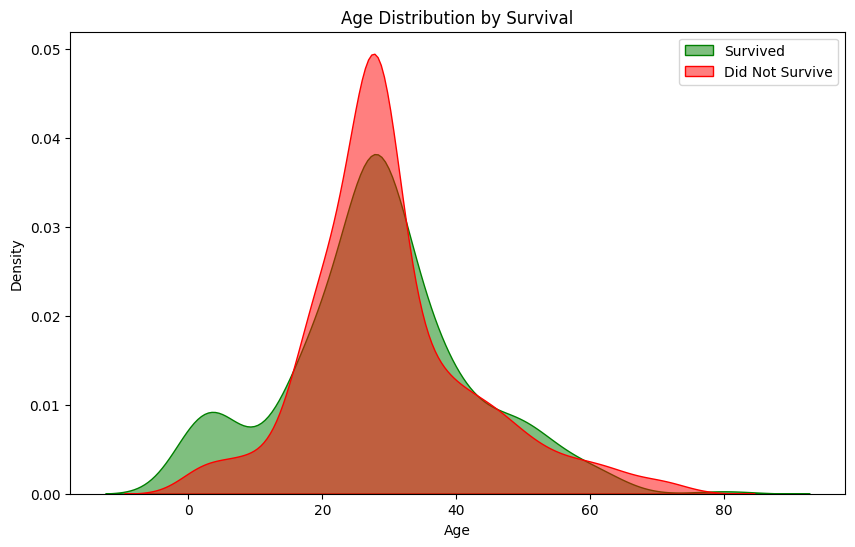

In [ ]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=data[data['Survived'] == 1], x='Age', fill=True, label='Survived', color='green', alpha=0.5)
sns.kdeplot(data=data[data['Survived'] == 0], x='Age', fill=True, label='Did Not Survive', color='red', alpha=0.5)
plt.title('Age Distribution by Survival')
plt.xlabel('Age')
plt.ylabel('Density')
plt.legend()
plt.show()

# Fare distribution by survival

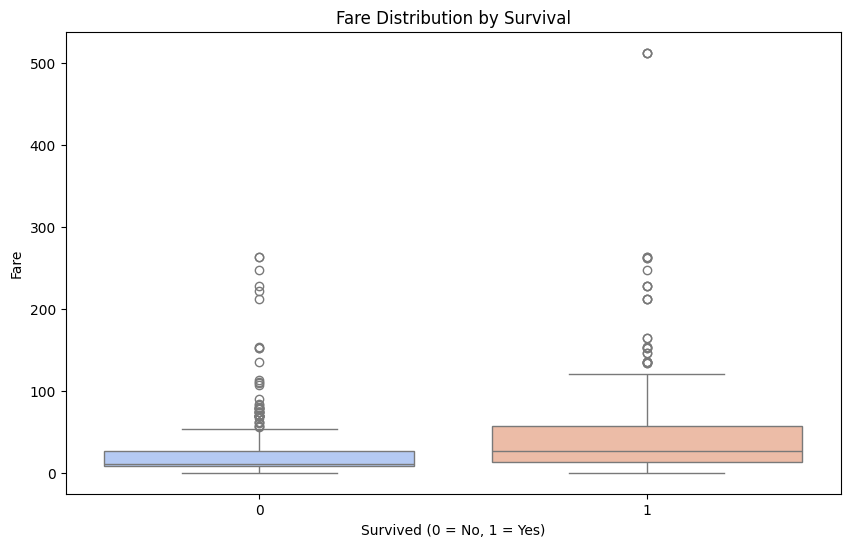

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Survived', y='Fare', data=data, palette='coolwarm')
plt.title('Fare Distribution by Survival')
plt.xlabel('Survived (0 = No, 1 = Yes)')
plt.ylabel('Fare')
plt.show()

# Survival rate by Pclass

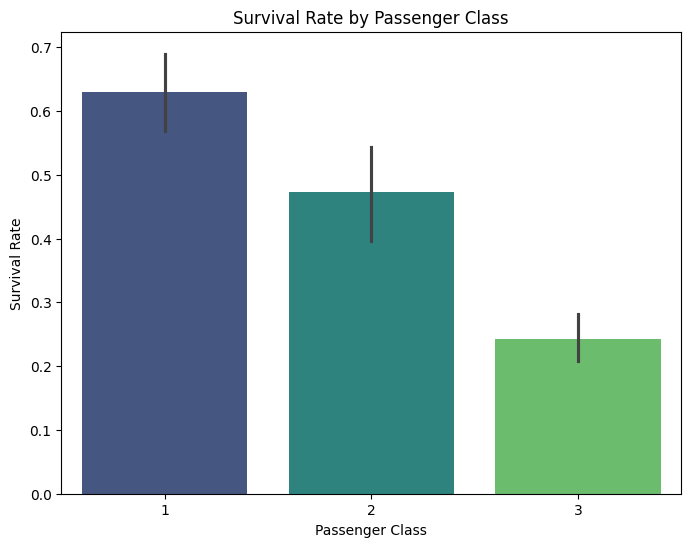

In [ ]:
plt.figure(figsize=(8, 6))
sns.barplot(x='Pclass', y='Survived', data=data, palette='viridis')
plt.title('Survival Rate by Passenger Class')
plt.xlabel('Passenger Class')
plt.ylabel('Survival Rate')
plt.show()